import dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Appending all the dataset into a list

In [2]:
data = []
fileNum = 2
while fileNum < 115: 
    with open('data/logs-insights-results-' + str(fileNum) + '.csv') as f:
        for line in csv.DictReader(f, fieldnames=('timestamp', 'message')):
            data.append(line)
        fileNum += 1

In [3]:
len_of_data = len(data)
len_of_data

822226

In [4]:
print(data[0])

{'timestamp': '@timestamp', 'message': '@message'}


This following decodes to message into different attributes:
<li>account: the account of the user </li>
<li>sourceIP: the ip address of the sender of the message</li>
<li>destIP: the receiver of the message</li>
<li>interface: the log stream of the message</li>
<li>srcPort: internet port of sender</li>
<li>dstPort: internet port of receiver</li>
<li>protocol: the network protocol used to communicate the message</li>
<li>byte: the size of the message</li>
<li>packets: number of segments of the message</li>
<li>startTime: the integer start time in unix time form</li>
<li>timeTook: exact time it took to send the message</li>
<li>status: either "ACCEPT" or "REJECT". Accept will be 1 and reject will be represented as 0.</li>

In [5]:
date = []
time = []
account = []
sourceIP = []
destIP = []
interface = []
srcPort = []
dstPort = []
protocol = []
byte = []
packets = []
startTime = []
timeTook = []
status = []

na = None
i = 1

while i < len(data):
    msg = data[i].get('message',na)
    # for messages with no data will get filtered out here
    if 'ACCEPT' in msg or 'REJECT' in msg:
        timeTokens = data[i].get('timestamp',na).split()
        date.append(timeTokens[0])
        time.append(timeTokens[1])
        tokens = msg.split()
        account.append(tokens[1])
        interface.append(tokens[2])
        sourceIP.append(tokens[3])
        destIP.append(tokens[4])
        #storing actions
        temp = 5
        tempStr = ''
        while(tokens[temp+1] != "OK"):
            tempStr = tempStr + tokens[temp] + ' '
            temp += 1
        actionTokens = tempStr.split()
        srcPort.append(actionTokens[0])
        dstPort.append(actionTokens[1])
        protocol.append(actionTokens[2])
        packets.append(actionTokens[3])
        byte.append(actionTokens[4])
        startTime.append(int(actionTokens[5]))
        timeTook.append(int(actionTokens[6]) - int(actionTokens[5]))
        if(tokens[temp] == 'ACCEPT'):
            status.append(1)
        else:
            status.append(0)
    i += 1
# print label as well
print('Date: ' + date[0])
print('Time: ' + time[0])
print('AWS account: ' + account[0])
print('Network interface: ' + interface[0])
print('Source IP: ' + sourceIP[0])
print('Destination IP: ' + destIP[0])
print('Status: ' + str(status[0]))
print('Source port: ' + srcPort[0])
print('Destination port: ' + dstPort[0])
print('Protocol: ' + protocol[0])
print('Packets of data: ' + packets[0])
print('Size of data: ' + byte[0] + ' bytes')
print('Start time: ' + str(startTime[0]))
print('Time used: ' + str(timeTook[0]) + ' seconds')
print('New size of dataset after filtering: ' + str(len(date)))

Date: 2021-02-10
Time: 18:15:00.000
AWS account: 430405884063
Network interface: eni-0b6ce86ea40aaa41b
Source IP: 50.245.225.205
Destination IP: 172.16.1.52
Status: 1
Source port: 9622
Destination port: 80
Protocol: 6
Packets of data: 5
Size of data: 582 bytes
Start time: 1612980900
Time used: 9 seconds
New size of dataset after filtering: 813100


Creating the pandas dataframe

In [6]:
df = pd.DataFrame({
    "date":date,
    "time":time,
    "account":account,
    "interface":interface,
    "sourceIP":sourceIP,
    "destIP":destIP,
    "srcPort":srcPort,
    "dstPort":dstPort,
    "protocol":protocol,
    "packets":packets,
    "byte":byte,
    "startTime":startTime,
    "timeTook":timeTook,
    "status":status
})

In [7]:
df.head(10)

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1
5,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1
6,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,49748,80,6,7,705,1612980900,9,1
7,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1
8,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,18681,80,6,5,572,1612980900,9,1
9,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1


In [8]:
df.columns

Index(['date', 'time', 'account', 'interface', 'sourceIP', 'destIP', 'srcPort',
       'dstPort', 'protocol', 'packets', 'byte', 'startTime', 'timeTook',
       'status'],
      dtype='object')

Remove features that are not interested

In [9]:
df.pop('date')
df.pop('time')
df.pop("account")
df.pop("interface")
df.pop('srcPort')
df.pop('dstPort')
df.pop('protocol')
df.pop('packets')
df.pop('byte')
df.pop('timeTook')

# Reformat numbers
df['startTime'] = pd.to_numeric(df['startTime'])
df['status'] = pd.to_numeric(df['status'])

df.head()

,sourceIP,destIP,startTime,status
0,50.245.225.205,172.16.1.52,1612980900,1
1,172.16.1.52,50.245.225.205,1612980900,1
2,50.245.225.205,172.16.1.52,1612980900,1
3,172.16.1.52,50.245.225.205,1612980900,1
4,50.245.225.205,172.16.1.52,1612980900,1


Sorting the values by time, source ip address, and destination ip address for data pre-process

In [10]:
df = df.sort_values(['startTime','sourceIP', 'destIP',],ascending=[True, True, True])
df = df.reset_index(drop=True)
df.head()

,sourceIP,destIP,startTime,status
0,172.16.1.196,172.16.1.52,1612980720,1
1,172.16.1.196,172.16.1.52,1612980720,1
2,172.16.1.196,172.16.1.52,1612980720,1
3,172.16.1.196,172.16.1.52,1612980720,1
4,172.16.1.196,172.16.1.52,1612980720,1


Because an attacked is considered as an abnormal behavior in the dataset which the number of requests from a single ip address is much greater than the average. We combine the rows if the source IP, destination IP, and start time are the same, creating a new column called numOfRequest that keeps track of the number of duplicate requests for each second, and acceptanceRate that summerize the total accuracy of ACCEPT/REJECT

In [11]:
#preprocess the data
#O(n)
processedDf = pd.DataFrame({
    "sourceIP":[],
    "destIP":[],
    "numOfRequest":[],
    "time":[],
    "acceptanceRate":[],
})
for index, line in df.iterrows():
    if index == 0:
        m = 100
        if line['status'] == 0:
            m = 0
        processedDf.loc[0] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
    else:
        n = len(processedDf)-1
        if processedDf.loc[n,'sourceIP']==line['sourceIP'] and processedDf.loc[n,'destIP']==line['destIP'] and processedDf.loc[n,'time']==line['startTime']:
            x = processedDf.loc[n,'numOfRequest']
            processedDf.loc[n,'numOfRequest'] = x + 1
            if line['status'] == 1:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01)+1)/(x+1)) * 100
            else:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01))/(x+1)) * 100
        else:
            m = 100
            if line['status'] == 0:
                m = 0
            processedDf.loc[n+1] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
processedDf.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0


In [12]:
processedDf.to_csv('processed_data.csv')

In [4]:
df = pd.read_csv('processed_data.csv')
df.pop('Unnamed: 0')
df.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0


Because the dataset does not contain a supervised information to determine the response being whether an attack, unsupervised machine learning is used to determine the attacks and not attacks. KMeans clustering groups the the dataset around 2 centroids. Then, logistic regression is used to produce the likeihood of each response being an attack by the machine. The K-mean cluster result is used as a superviser for the logictic regression.

In [5]:
from numpy import nan
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

unsupervised learning using k-means clustering

In [6]:
X = df.loc[:, ['numOfRequest', 'acceptanceRate']]
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
df['is_attack'] = kmeans.labels_
df['is_attack'].value_counts()

0    43594
1      775
2      145
Name: is_attack, dtype: int64

some explanation here on what clusters are 

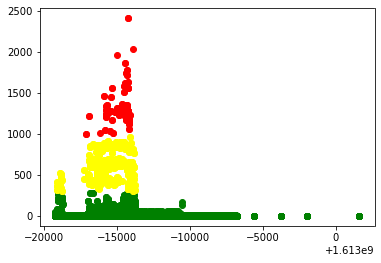

<Figure size 432x288 with 0 Axes>

In [7]:
filtered_label0 = df[df['is_attack']==0]
filtered_label1 = df[df['is_attack']==1]
filtered_label2 = df[df['is_attack']==2]
 
#Plotting the results
plt.scatter(filtered_label0['time'] ,filtered_label0['numOfRequest'] , color = 'green')
plt.scatter(filtered_label1['time'] ,filtered_label1['numOfRequest'] , color = 'yellow')
plt.scatter(filtered_label2['time'] ,filtered_label2['numOfRequest'] , color = 'red')

plt.show()
plt.savefig('cluster_graph_1.png', dpi = 300)

supervised learning using logictic regression

In [8]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
y = df['is_attack'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = LogisticRegression(random_state=0, verbose=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14349
           1       0.99      1.00      1.00       289
           2       1.00      0.96      0.98        52

    accuracy                           1.00     14690
   macro avg       1.00      0.99      0.99     14690
weighted avg       1.00      1.00      1.00     14690



/Users/alexshen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


The report above indicates how many responses are considered as not attacks, how many as gray area, and how many definitly attacks.

In [9]:
df['is_attack_supervised'] = clf.predict_proba(X)[:,1]
df.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0,0,0.0
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0,0,0.0
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0,0,0.0
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0,0,0.0
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0,0,0.0


Here is the sorted dataset based on the probability of attacks, the result is showing that for over a few hundred responses in 1 second are highly considered an attack.

In [10]:
suspicious_activity = df.sort_values(by='is_attack_supervised',ascending=False)
suspicious_activity = suspicious_activity[suspicious_activity['is_attack']==2]
suspicious_activity.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised
8187,10.3.252.33,172.16.1.245,999.0,1.612983e+09,100.0,2,0.540736
8189,172.16.1.245,10.3.252.33,999.0,1.612983e+09,100.0,2,0.540736
14002,172.16.1.52,172.16.1.196,1016.0,1.612985e+09,100.0,2,0.430807
14000,172.16.1.196,172.16.1.52,1016.0,1.612985e+09,100.0,2,0.430807
13333,172.16.1.52,172.16.1.196,1030.0,1.612985e+09,100.0,2,0.344693


Do a k-means cluster with 2 clusters to seperate the responses in the gray area

In [11]:
grayArea = df[df['is_attack']==1]

X = grayArea.loc[:, ['numOfRequest', 'acceptanceRate']]
kmeans = KMeans(n_clusters = 2) # is attack or not attack into 2 clusters
kmeans.fit(X)
grayArea['possible_sus'] = kmeans.labels_
grayArea['possible_sus'].value_counts()

<ipython-input-11-36ea3d716cf7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grayArea['possible_sus'] = kmeans.labels_


0    567
1    208
Name: possible_sus, dtype: int64

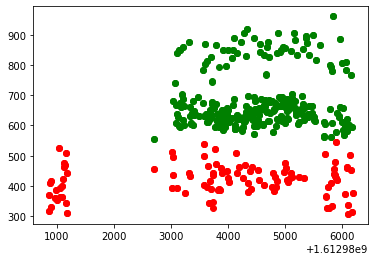

<Figure size 432x288 with 0 Axes>

In [12]:
filtered_label0 = grayArea[grayArea['possible_sus']==0]
filtered_label1 = grayArea[grayArea['possible_sus']==1]
 
#Plotting the results
plt.scatter(filtered_label0['time'] ,filtered_label0['numOfRequest'] , color = 'green')
plt.scatter(filtered_label1['time'] ,filtered_label1['numOfRequest'] , color = 'red')

plt.show()
plt.savefig('cluster_graph_2.png', dpi = 300)

In [13]:
grayArea.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised,possible_sus
594,172.16.1.52,50.245.225.205,318.0,1.612981e+09,100.0,1,1.0,1
595,50.245.225.205,172.16.1.52,318.0,1.612981e+09,100.0,1,1.0,1
695,172.16.1.52,50.245.225.205,370.0,1.612981e+09,100.0,1,1.0,1
700,50.245.225.205,172.16.1.52,370.0,1.612981e+09,100.0,1,1.0,1
770,172.16.1.52,50.245.225.205,409.0,1.612981e+09,100.0,1,1.0,1


In [14]:
suspicious_activity.count()

sourceIP                145
destIP                  145
numOfRequest            145
time                    145
acceptanceRate          145
is_attack               145
is_attack_supervised    145
dtype: int64

Merge the gray area responses that's classified as suspicious activities with others

In [15]:
grayAreaSus = grayArea[grayArea['possible_sus'] == 1]
grayAreaSus.pop('possible_sus')

594      1
595      1
695      1
700      1
770      1
        ..
19313    1
19404    1
19410    1
19461    1
19463    1
Name: possible_sus, Length: 208, dtype: int32

In [16]:
suspicious_activity = pd.concat([suspicious_activity, grayAreaSus], ignore_index=True)
suspicious_activity['likelihood'] = suspicious_activity['numOfRequest']/suspicious_activity['numOfRequest'].max()
suspicious_activity = suspicious_activity.sort_values(by='likelihood',ascending=False)
suspicious_activity.count()

sourceIP                353
destIP                  353
numOfRequest            353
time                    353
acceptanceRate          353
is_attack               353
is_attack_supervised    353
likelihood              353
dtype: int64

The threshold for the number of requests considered as an attack is 410 per second

In [17]:
suspicious_activity['likelihood'] = suspicious_activity['likelihood'] * 100
suspicious_activity.sort_values(by='numOfRequest',ascending=True)

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised,likelihood
344,172.16.1.52,172.16.1.196,307.0,1.612986e+09,100.000000,1,9.999756e-01,12.738589
343,172.16.1.196,172.16.1.52,307.0,1.612986e+09,100.000000,1,9.999756e-01,12.738589
183,172.16.1.52,50.245.225.205,310.0,1.612981e+09,100.000000,1,1.000000e+00,12.863071
184,50.245.225.205,172.16.1.52,310.0,1.612981e+09,100.000000,1,1.000000e+00,12.863071
349,172.16.1.52,73.180.143.70,315.0,1.612986e+09,100.000000,1,1.000000e+00,13.070539
...,...,...,...,...,...,...,...,...
140,172.16.1.52,172.16.1.196,1866.0,1.612986e+09,100.000000,2,1.923408e-10,77.427386
141,10.3.252.33,172.16.1.241,1965.0,1.612985e+09,0.152672,2,6.927444e-14,81.535270
142,10.3.252.33,172.16.1.241,2034.0,1.612986e+09,0.245821,2,1.158400e-14,84.398340
144,172.16.1.196,172.16.1.52,2410.0,1.612986e+09,100.000000,2,1.390921e-16,100.000000


In [18]:
suspicious_activity['time'] = pd.to_datetime(suspicious_activity['time'],unit='s')
df['time'] = pd.to_datetime(df['time'],unit='s')

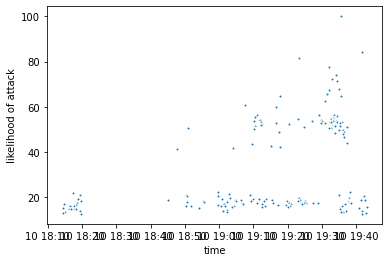

<Figure size 432x288 with 0 Axes>

In [19]:
plt.scatter(suspicious_activity['time'], suspicious_activity['likelihood'], marker='.', edgecolors='white')
plt.xlabel("time")
plt.ylabel("likelihood of attack")
plt.show()
plt.savefig('suspicious_activity.png', dpi = 300)

In [20]:
number_of_suspicious = 0
for index, line in suspicious_activity.iterrows():
    number_of_suspicious = number_of_suspicious + line["numOfRequest"]
print("There are total number of " + str(number_of_suspicious) + " suspicious activities among the overall " + str(len_of_data) + " number of responses. ")
print("The number of unique suspicious activities are " + str(len(suspicious_activity)) + " with the highest duplicate of " + str(suspicious_activity["numOfRequest"].max()) + " among them.")

There are total number of 281411.0 suspicious activities among the overall 822226 number of responses. 
The number of unique suspicious activities are 353 with the highest duplicate of 2410.0 among them.


In [21]:
df.to_csv('result.csv')
suspicious_activity.to_csv('suspicious_activity.csv')

The idea of detecting web attacks through machine learning is not a brand new topic, but an area that still needs better development and research on. This project analyzied around 8000000 log flow records from a software company's user log in page in a 5 hour range. After pre-process its data, the machine detected some records being potential attacks and gave its likeihood based on its suspicious behaviors. 

The project first process the data into pandas dataframe, then omit all the features of the record that are not interested in detecting the attacks. Next, the data is being compressed from 8000000 datas to around 40000 by combining the records that has the same source and destination ip address in the same unix time. The higher rate the compression is, the more duplicate responsed there is in the dataset. This significantly improved the efficiency of machine learning. Then, unsupervised machine learning was applied to give the detection of the dataset using K-means clustering. The three clusters each represents not-suspicious, suspicious, and gray area. 

Training/testing the data into 0.66/0.33 to analyze the likeihood of each response' abnormal behaviors, and use the previous result as a superviser for accuracy. The gray area is again using k-mean clustering to seperate into 2 clusters, labeled as "more suspicious" and "less suspicious". The "more suspicious" are added into the suspicious_activity dataset. Doing so ensures the machine does not miss any responsed that gets filtered out from the analysis but still remain an abnormal behavior. The likelihood of the suspicious is calculated based on the percentage over the maximum response in 1 second.

The initial approach of this problem was to use k-mean clustering based on how much time it took to process the response. However, this is not significant due to the delay from each server and unknown source of the dataset being analyzed. After researching on the definition of abnormal behaviors in reality, most of the features are filtered out because they do not have much impact in analyzing attacks. An attack for a general log-in page is defined as multiple visits, responses, callbacks in a short period of time. Thus, pre-processing the data by combining each duplicate responsed in the same second helps determine the responses' number of visits that stands out.

The 3-2 double-clustering technique helps the machine narrows down the suspicious activities. If k-means clustering is applied only once with 2 clusters, the uncertain groups of dataset's log records would possibly wrong the result. Therefore, creating a gray area in the middle of two certainties helps detecting the potential attacks that could be missed.

The result is saved into result.csv and all detected attacks are saved in suspicious_activity.csv

References:

<li>Gong, X., Zhou, Y., Bi, Y., He, M., Sheng, S., Qiu, H., He, R., & Lu, J. (2019, October 3). Estimating web attack detection via model uncertainty from inaccurate annotation. IEEE Xplore. https://ieeexplore.ieee.org/abstract/document/8854029. 
<br>
    
This article illustrated the potential attacks in log records that are not successfully recorded, which are label as "unknown". This project is aware of the situation from this article. All the unknown log flow records has no source and destinition ip address, therefore are all filtered out before creating the panda dataframe to avoid it reducing the accuracy of the result.</li>

<li>Tian, Z., Luo, C., Qiu, J., Du, X., & Guizani, M. (2019, August 30). A distributed deep learning system for web attack detection on edge devices. IEEE Xplore. https://ieeexplore.ieee.org/document/8821336. 
<br>
    
In this article, the author developed a machine learning model using deep learning to detect web attacks by analyzing its URLs. The result has a high accuracy. The approach of machine learning was inpired into this project in which the arthor created a system that solves challenges in the paradigm of the Edge of Things.</li>

<li>Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. O'Reilly Media, Inc.
<br>
    
The idea of using K-means clustering, sklearn, data split, training, and testing machine learning algorithms to apply into this project is inspired from this book.  </li>

<li>Torrano-Gimenez, C., Franke, K., Alvarez, G., & Nguyen, H. T. (2012, August 29). Combining expert knowledge with automatic feature extraction for reliable web attack detection. https://onlinelibrary.wiley.com/doi/epdf/10.1002/sec.603. 
<br>
    
This article discussed the feature construction and feature selection of the web attack detaction. This project applied the idea of omiting the features that are not intertested in attack detection. </li>

<li>Betarte, G., Pardo, Á., &amp; Martínez, R. (2019, January 17). Web application attacks detection using machine learning techniques. IEEE Xplore. https://ieeexplore.ieee.org/document/8614199. 
<br>


</li>

<li>Abdulraheem, M., &amp; Ibraheem, N. (2019). A DETAILED ANALYSIS OF NEW INTRUSION DETECTION DATASET. http://www.jatit.org/volumes/Vol97No17/4Vol97No17.pdf</li>

https://github.com/p-neumann/User-Behavior-Analysis-and-Prediction